# Breast cancer diagnosis
#### Dataset is downloaded from here: https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/

## Importing Libraries and Modules

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D,Input,Dropout
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools 
from tensorflow.keras.utils import to_categorical
from imutils import paths
import os
import shutil 
import random
import glob
import matplotlib.pyplot as plt
import warnings 
from keras.utils import np_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np
warnings.simplefilter(action='ignore', category = FutureWarning)
%matplotlib inline
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import cv2

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Number of GPUs Available',len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Number of GPUs Available 1


##  Loading the datasets

In [3]:
train_path = 'dataset/BreaKHis_splitted/training'
valid_path = 'dataset/BreaKHis_splitted/validation'
test_path = 'dataset/BreaKHis_splitted/testing'

In [4]:
trainAug = ImageDataGenerator(
	rescale=1 / 255.0,
	rotation_range=20,
	zoom_range=0.05,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.05,
	horizontal_flip=True,
	vertical_flip=True,
	fill_mode="nearest")

valAug = ImageDataGenerator(
    rescale=1 / 255.0)
testAug = ImageDataGenerator(
    rescale=1 / 255.0)

In [5]:
train_batches = trainAug.flow_from_directory(directory=train_path, class_mode="categorical",target_size=(224,224),color_mode="rgb", classes=['adenosis','ductal_carcinoma','fibroadenoma','lobular_carcinoma','mucinous_carcinoma','Normal','papillary_carcinoma', 'phyllodes_tumor','tubular_adenoma'], shuffle=True,batch_size=32)
valid_batches = valAug.flow_from_directory(directory=valid_path,class_mode="categorical",target_size=(224,224),color_mode="rgb", classes=['adenosis','ductal_carcinoma','fibroadenoma','lobular_carcinoma','mucinous_carcinoma','Normal','papillary_carcinoma', 'phyllodes_tumor','tubular_adenoma'], batch_size=32,shuffle=False)
test_batches = testAug.flow_from_directory(directory=test_path, class_mode="categorical",target_size=(224,224),color_mode="rgb", classes=['adenosis','ductal_carcinoma','fibroadenoma','lobular_carcinoma','mucinous_carcinoma','Normal','papillary_carcinoma', 'phyllodes_tumor','tubular_adenoma'], batch_size=32 , shuffle=False)

Found 5767 images belonging to 9 classes.
Found 640 images belonging to 9 classes.
Found 1602 images belonging to 9 classes.


In [6]:
totalTrain = len(list(paths.list_images(train_path)))
print(totalTrain)
totalVal = len(list(paths.list_images(valid_path)))
print(totalVal)
totalTest = len(list(paths.list_images(test_path)))
print(totalTest)

5767
640
1602


In [7]:
trainLabels = train_batches.classes

## Handling unbalanced data

In [8]:
trainLabels = to_categorical(trainLabels)

In [9]:
trainLabels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [10]:
classTotals = trainLabels.sum(axis=0)

In [11]:
classTotals

array([ 320., 2473.,  731.,  458.,  562.,   72.,  417.,  307.,  427.],
      dtype=float32)

In [12]:
classWeight = dict()

In [13]:
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

In [14]:
classWeight

{0: 7.728125,
 1: 1.0,
 2: 3.3830369,
 3: 5.3995633,
 4: 4.400356,
 5: 34.34722,
 6: 5.9304557,
 7: 8.055374,
 8: 5.791569}

In [15]:
BATCH_SIZE = 32

In [16]:
imgs, labels = next(train_batches)

In [17]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

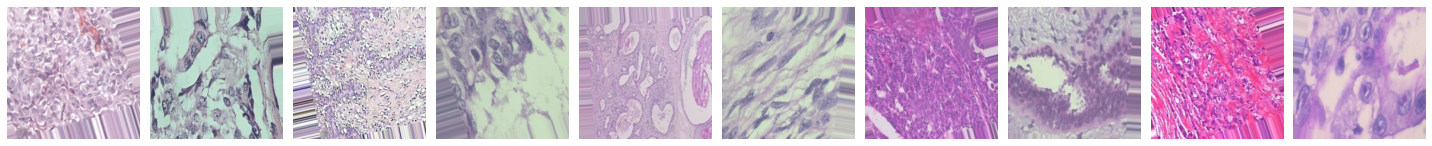

[[0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [18]:
plotImages(imgs)
print(labels)

## Choosing the VGG16 model

In [26]:
baseModel = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

In [27]:
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(9, activation="softmax")(headModel)

In [28]:
model = tf.keras.Model(inputs=baseModel.input, outputs=headModel)

In [29]:
for layer in baseModel.layers:
	layer.trainable = False

## Model compilation

In [30]:
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

## Model training

In [31]:
print("[INFO] training head...")
H = model.fit(
	x=train_batches,
	steps_per_epoch=totalTrain // BATCH_SIZE,
	validation_data=valid_batches,
	validation_steps=totalVal // BATCH_SIZE,
    class_weight=classWeight,
	epochs=20)

[INFO] training head...
Epoch 1/20
180/180 [==============================] - 123s 684ms/step - loss: 8.8828 - accuracy: 0.1015 - val_loss: 2.1981 - val_accuracy: 0.0594
Epoch 2/20
180/180 [==============================] - 106s 587ms/step - loss: 8.4451 - accuracy: 0.1254 - val_loss: 2.1536 - val_accuracy: 0.1750
Epoch 3/20
180/180 [==============================] - 108s 599ms/step - loss: 8.4381 - accuracy: 0.1325 - val_loss: 2.1352 - val_accuracy: 0.2812
Epoch 4/20
180/180 [==============================] - 107s 597ms/step - loss: 8.4233 - accuracy: 0.1568 - val_loss: 2.1875 - val_accuracy: 0.1141
Epoch 5/20
180/180 [==============================] - 107s 597ms/step - loss: 8.3297 - accuracy: 0.1407 - val_loss: 2.1516 - val_accuracy: 0.1531
Epoch 6/20
180/180 [==============================] - 128s 713ms/step - loss: 8.2684 - accuracy: 0.1503 - val_loss: 2.0661 - val_accuracy: 0.3922
Epoch 7/20
180/180 [==============================] - 112s 621ms/step - loss: 8.1868 - accuracy: 0.1

In [32]:
train_batches.reset()
valid_batches.reset()

In [33]:
for layer in baseModel.layers[1:]:
	layer.trainable = True

In [34]:
for layer in baseModel.layers:
	print("{}: {}".format(layer, layer.trainable))

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000246F7996F10>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000246F79AE550>: True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000246F79ABBE0>: True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000246F79AEFD0>: True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000246F79B1970>: True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000246F79B4190>: True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000246F79B4BE0>: True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000246F79B6850>: True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000246F79B90A0>: True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000246F79B9AC0>: True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000246F79B4BB0>: True
<tensorflow.python

In [35]:
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [77]:
H = model.fit(
	x=train_batches,
	steps_per_epoch=totalTrain // BATCH_SIZE,
	validation_data=valid_batches,
	validation_steps=totalVal // BATCH_SIZE,
    class_weight=classWeight,
	epochs=10)

Epoch 1/10
180/180 [==============================] - 155s 859ms/step - loss: 0.0581 - accuracy: 0.9845 - val_loss: 0.3068 - val_accuracy: 0.9234
Epoch 2/10
180/180 [==============================] - 157s 874ms/step - loss: 0.0421 - accuracy: 0.9867 - val_loss: 0.3264 - val_accuracy: 0.9250
Epoch 3/10
180/180 [==============================] - 158s 877ms/step - loss: 0.0435 - accuracy: 0.9869 - val_loss: 0.3544 - val_accuracy: 0.9266
Epoch 4/10
180/180 [==============================] - 161s 895ms/step - loss: 0.0504 - accuracy: 0.9861 - val_loss: 0.3387 - val_accuracy: 0.9203
Epoch 5/10
180/180 [==============================] - 165s 915ms/step - loss: 0.0432 - accuracy: 0.9869 - val_loss: 0.3344 - val_accuracy: 0.9234
Epoch 6/10
180/180 [==============================] - 159s 885ms/step - loss: 0.2892 - accuracy: 0.9599 - val_loss: 0.3969 - val_accuracy: 0.8844
Epoch 7/10
180/180 [==============================] - 160s 891ms/step - loss: 0.0758 - accuracy: 0.9817 - val_loss: 0.3041 -

## Model evaluation on test data

In [78]:
test_batches.classes

array([0, 0, 0, ..., 8, 8, 8])

In [79]:
predictions = model.predict(test_batches)

In [80]:
np.round(predictions)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [81]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [82]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [83]:
test_batches.class_indices

{'adenosis': 0,
 'ductal_carcinoma': 1,
 'fibroadenoma': 2,
 'lobular_carcinoma': 3,
 'mucinous_carcinoma': 4,
 'Normal': 5,
 'papillary_carcinoma': 6,
 'phyllodes_tumor': 7,
 'tubular_adenoma': 8}

Confusion matrix, without normalization
[[ 79   1   0   0   0   0   0   1   0]
 [  0 670   1  29   4   0   4   0   0]
 [  0   1 194   0   0   0   0   0   5]
 [  0  16   0 110   1   0   0   0   0]
 [  0   5   0   1 153   0   4   0   3]
 [  0   0   0   1   0  19   0   0   0]
 [  0   4   1   0   0   0  94   0   0]
 [  0   1   9   0   0   0   2  96   0]
 [  0   1   1   0   0   0   0   0  91]]


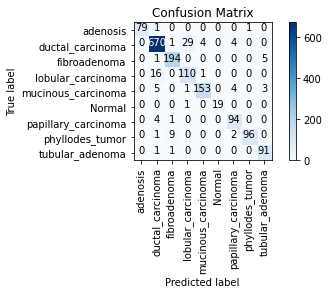

In [84]:
cm_plot_labels = ['adenosis','ductal_carcinoma','fibroadenoma','lobular_carcinoma','mucinous_carcinoma','Normal','papillary_carcinoma', 'phyllodes_tumor','tubular_adenoma']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [85]:
print(classification_report(test_batches.classes,np.argmax(predictions,axis=-1)))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        81
           1       0.96      0.95      0.95       708
           2       0.94      0.97      0.96       200
           3       0.78      0.87      0.82       127
           4       0.97      0.92      0.94       166
           5       1.00      0.95      0.97        20
           6       0.90      0.95      0.93        99
           7       0.99      0.89      0.94       108
           8       0.92      0.98      0.95        93

    accuracy                           0.94      1602
   macro avg       0.94      0.94      0.94      1602
weighted avg       0.94      0.94      0.94      1602



## Save the model to disk

In [86]:
model.save('saved model')

INFO:tensorflow:Assets written to: saved model\assets


In [87]:
model.save("saved_model", save_format="h5")